In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['font.family'] = 'Times'
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['figure.titlesize'] = 16

### 1. Process dataframe - dataset 1

In [3]:
# Import the results of Dataset1
df_1 = pd.read_csv('dataset1_result.csv')
df_1.columns

Index(['image_file', 'model_used', 'confidence', 'street', 'city', 'state',
       'country', 'latitude', 'longitude', 'usage_info', 'environment',
       'scene_type', 'setting', 'landmark_recognition', 'text_and_signage',
       'cultural_indicators', 'spatial_context', 'image_id', 'true_city',
       'true_country', 'true_latitude', 'true_longitude', 'distance_km',
       'model', 'country_match', 'city_match'],
      dtype='object')

In [4]:
# 1. Define all the USA name variants to treat as “USA”

usa_aliases = {
    'usa',
    'us',
    'united states',
    'united states of america'
}

# 2. A helper to normalize any country string
def normalize_country(name):
    name = str(name).strip().lower()
    if name in usa_aliases:
        return 'usa'
    return name

# 3. Apply to both columns and compare
df_1['country_norm']       = df_1['country'].apply(normalize_country)
df_1['true_country_norm']  = df_1['true_country'].apply(normalize_country)

df_1['country_match'] = (
    df_1['country_norm'] == df_1['true_country_norm']
)

# 4. (Optional) drop the helper cols if you like
df_1.drop(columns=['country_norm','true_country_norm'], inplace=True)

# 1. Define a mask for USA (adjust names as needed)
usa_mask = df_1['country'].str.lower().isin([
    'usa', 'united states', 'united states of america', 'us'
])

# 2. Filter to USA rows
usa_df = df_1[usa_mask]

# 3. Group by model and match flag, then unstack to get counts
counts = (
    usa_df
    .groupby(['model', 'country_match'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: 'incorrect', True: 'correct'})
)

# 4. keep only rows where true_country is not Taiwan
df_1 = df_1[df_1['true_country'] != 'Taiwan']

print(counts)

country_match     incorrect  correct
model                               
claude-3.5-haiku         78      732
gemini-1.5-pro            3      696
gemini-2.5-flash         20      760
gemini-2.5-pro           13      762
gpt-4.1                  33      763
gpt-4.1-mini             79      763
llama-3.2-11b           240      485
llama-3.2-90b            75      721
llama-4-17b              95      691
o3                       24      751


In [5]:
# Only countries with ≥ THRESHOLD_1 samples (true ground‑truth examples) are shown
THRESHOLD_1 = 20 

# 1. Count true_country samples per model & country
counts = (
    df_1
    .groupby(['model', 'true_country'])
    .size()
    .reset_index(name='n')
)

# 2. For each model, count how many countries exceed the THRESHOLD_1
result = (
    counts[counts['n'] > THRESHOLD_1]
    .groupby('model')
    .size()
    .reset_index(name='num_countries')
)

# 3. Display the results
print("Number of countries per model with more than "
      f"{THRESHOLD_1} true_country samples:")
print(result)


Number of countries per model with more than 20 true_country samples:
              model  num_countries
0  claude-3.5-haiku             40
1    gemini-1.5-pro             40
2  gemini-2.5-flash             40
3    gemini-2.5-pro             40
4           gpt-4.1             40
5      gpt-4.1-mini             40
6     llama-3.2-11b             40
7     llama-3.2-90b             40
8       llama-4-17b             40
9                o3             40


### 2. Plot heatmap - dataset 2

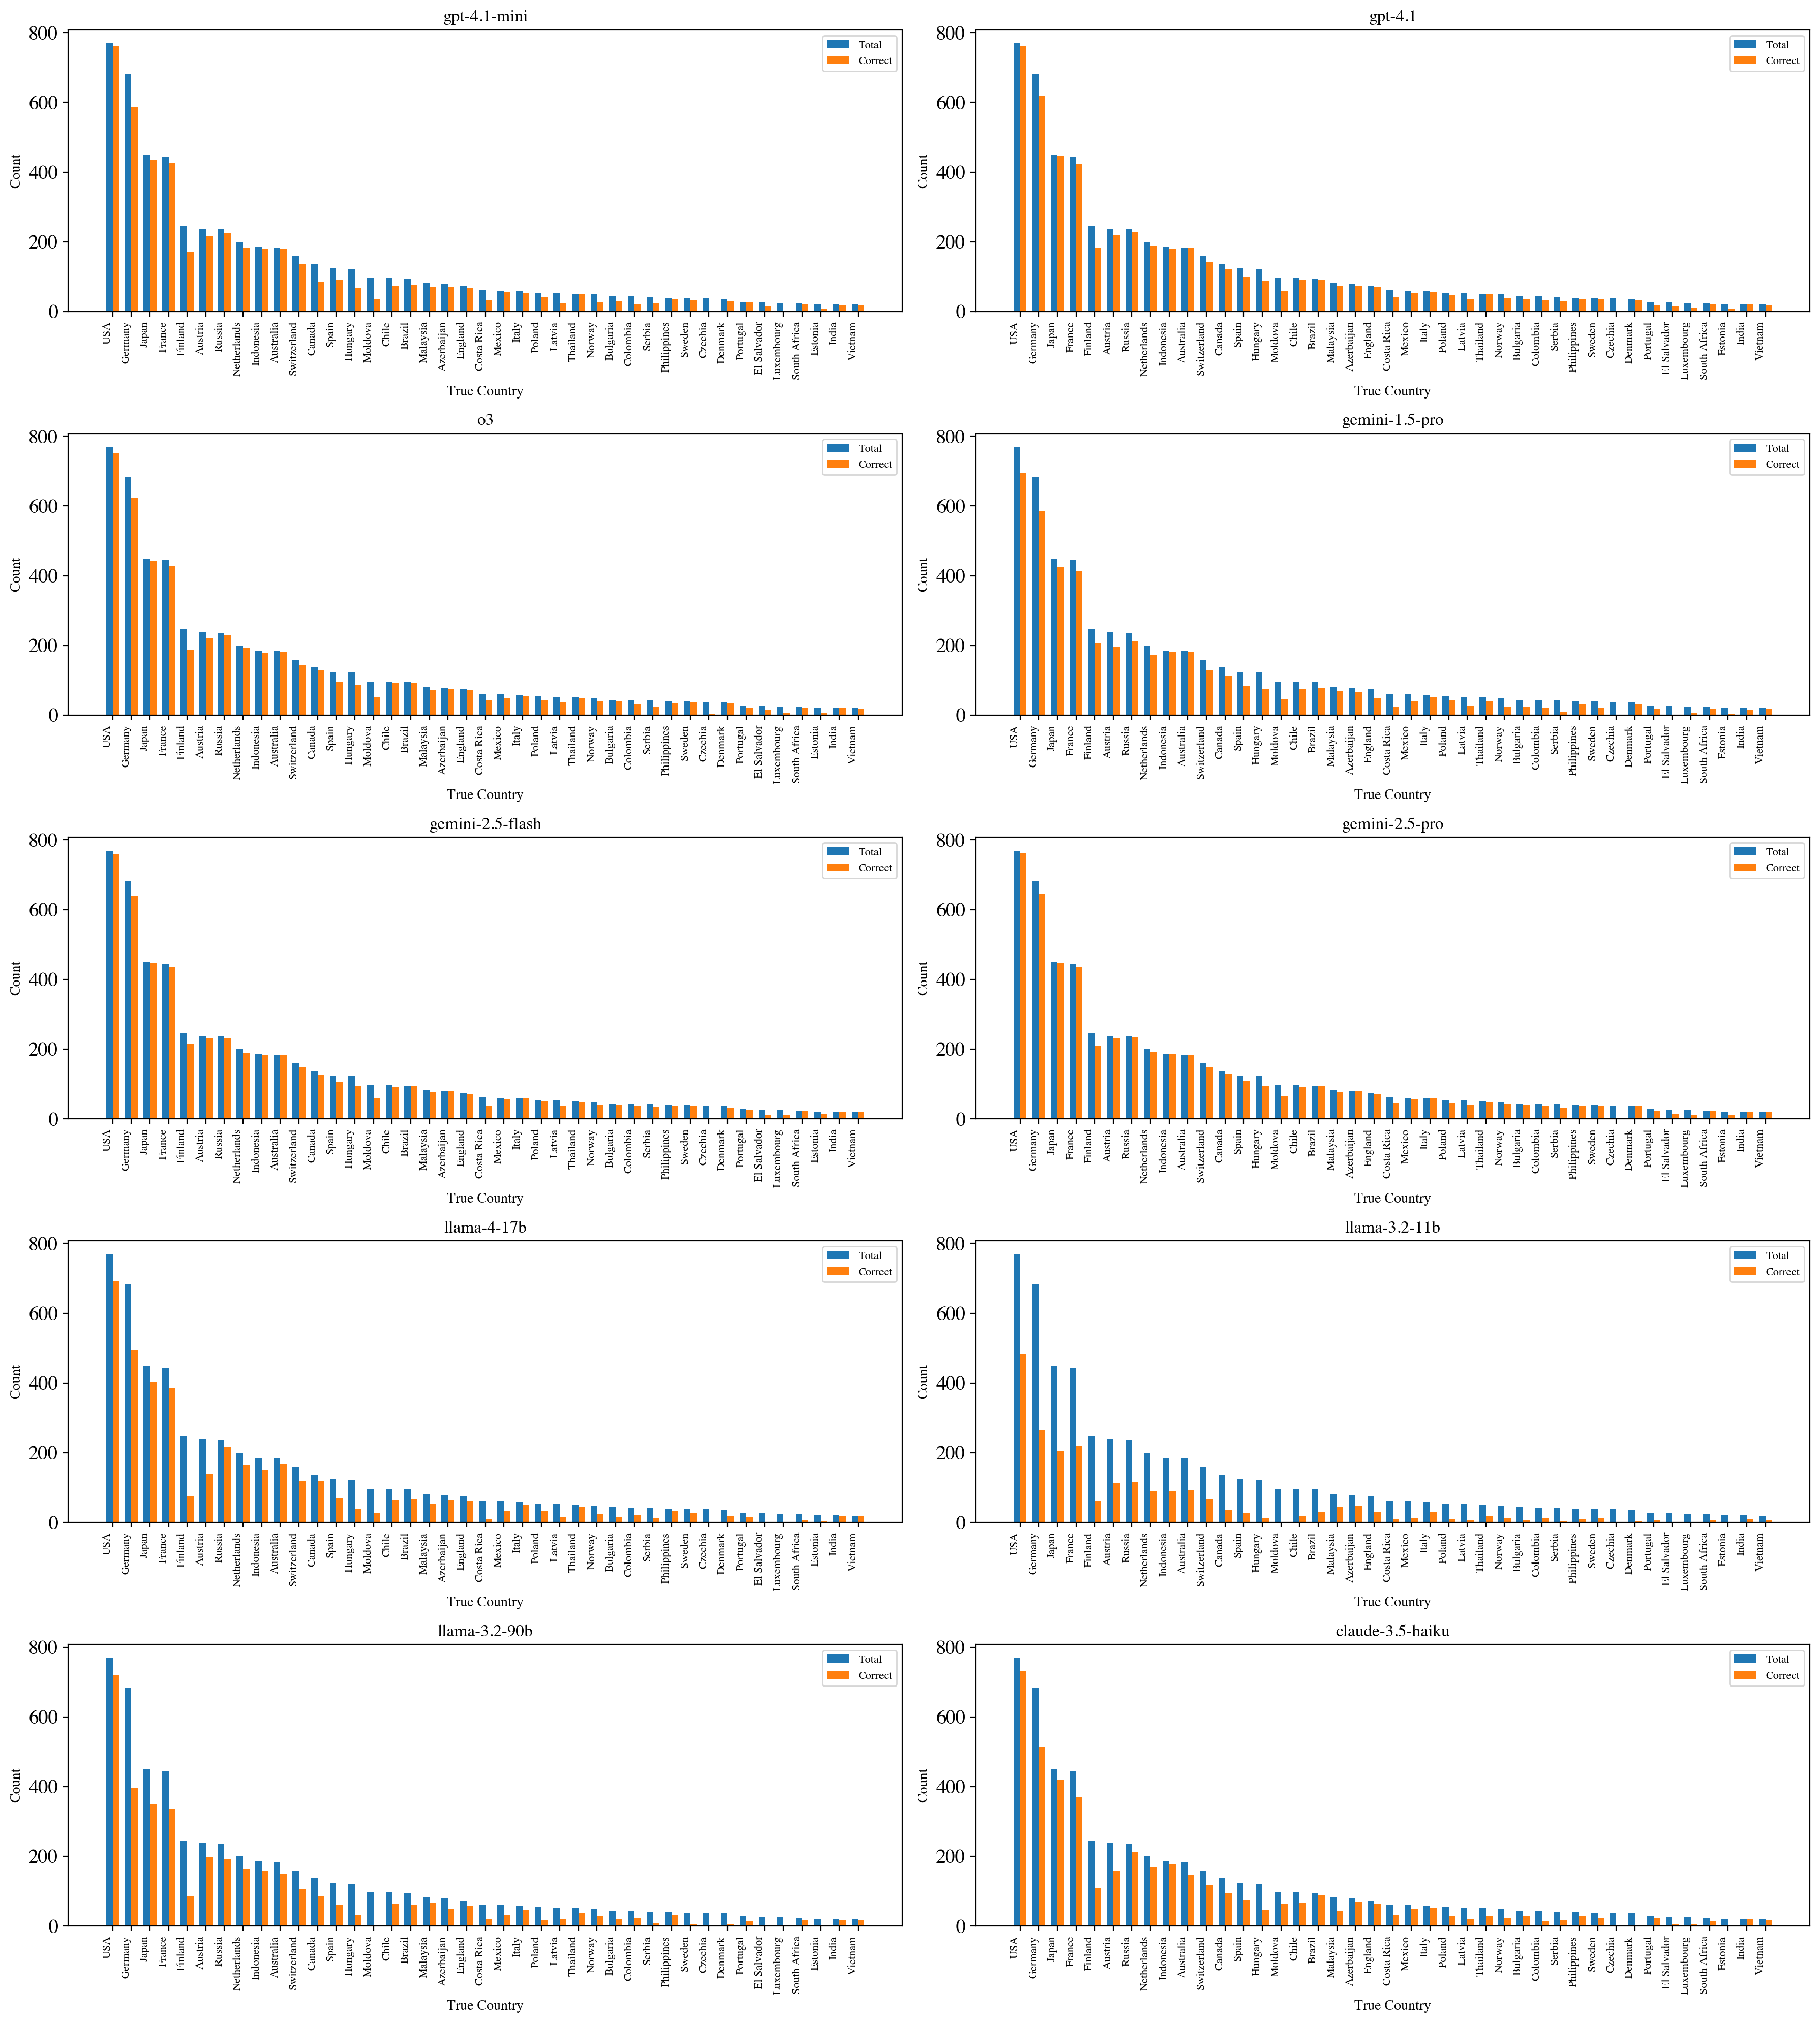

In [6]:
# Plot the histgram Figure
# 1. Get your models and compute grid size
model_order = [
    'gpt-4.1-mini',
    'gpt-4.1',
    'o3',
    'gemini-1.5-pro',
    'gemini-2.5-flash',
    'gemini-2.5-pro',
    'llama-4-17b',
    'llama-3.2-11b',
    'llama-3.2-90b',
    'claude-3.5-haiku',
]
models = model_order

n_models = len(models)
cols = 2
rows = (n_models + cols - 1) // cols  # ceil division

# 2. Set up the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4), dpi=200)
axes = axes.flatten()

# 3. Loop over models and plot on its own axis
for ax, model in zip(axes, models):
    # a) filter to this model
    df_m = df_1[df_1['model'] == model]

    # b) group by true_country
    stats = (
        df_m
        .assign(match_int=df_m['country_match'].astype(int))
        .groupby('true_country', as_index=False)
        .agg(
            total=('match_int', 'size'),     # number of ground‑truth examples
            correct=('match_int', 'sum')     # how many were predicted correctly
        )
        .query("total >= @THRESHOLD_1")                # only big enough bins
        .sort_values('total', ascending=False)
    )
    
    # c) if no bins pass THRESHOLD_1, hide axis
    if stats.empty:
        ax.set_visible(False)
        continue  

    # d) bar positions
    x = np.arange(len(stats))
    width = 0.35

    # e) draw bars
    ax.bar(x - width/2, stats['total'],   width, label='Total')
    ax.bar(x + width/2, stats['correct'], width, label='Correct')

    # f) formatting
    ax.set_title(model, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(stats['true_country'], rotation=90, ha='right', fontsize=8)
    ax.set_xlabel('True Country', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(fontsize=8)

# 4. Hide leftover axes if any
for ax in axes[n_models:]:
    ax.set_visible(False)

# 5. Final layout
plt.tight_layout()
plt.show()

/var/folders/l0/f3brd6kd23d1j64rj2yz5r100000gp/T/ipykernel_74143/2898236877.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


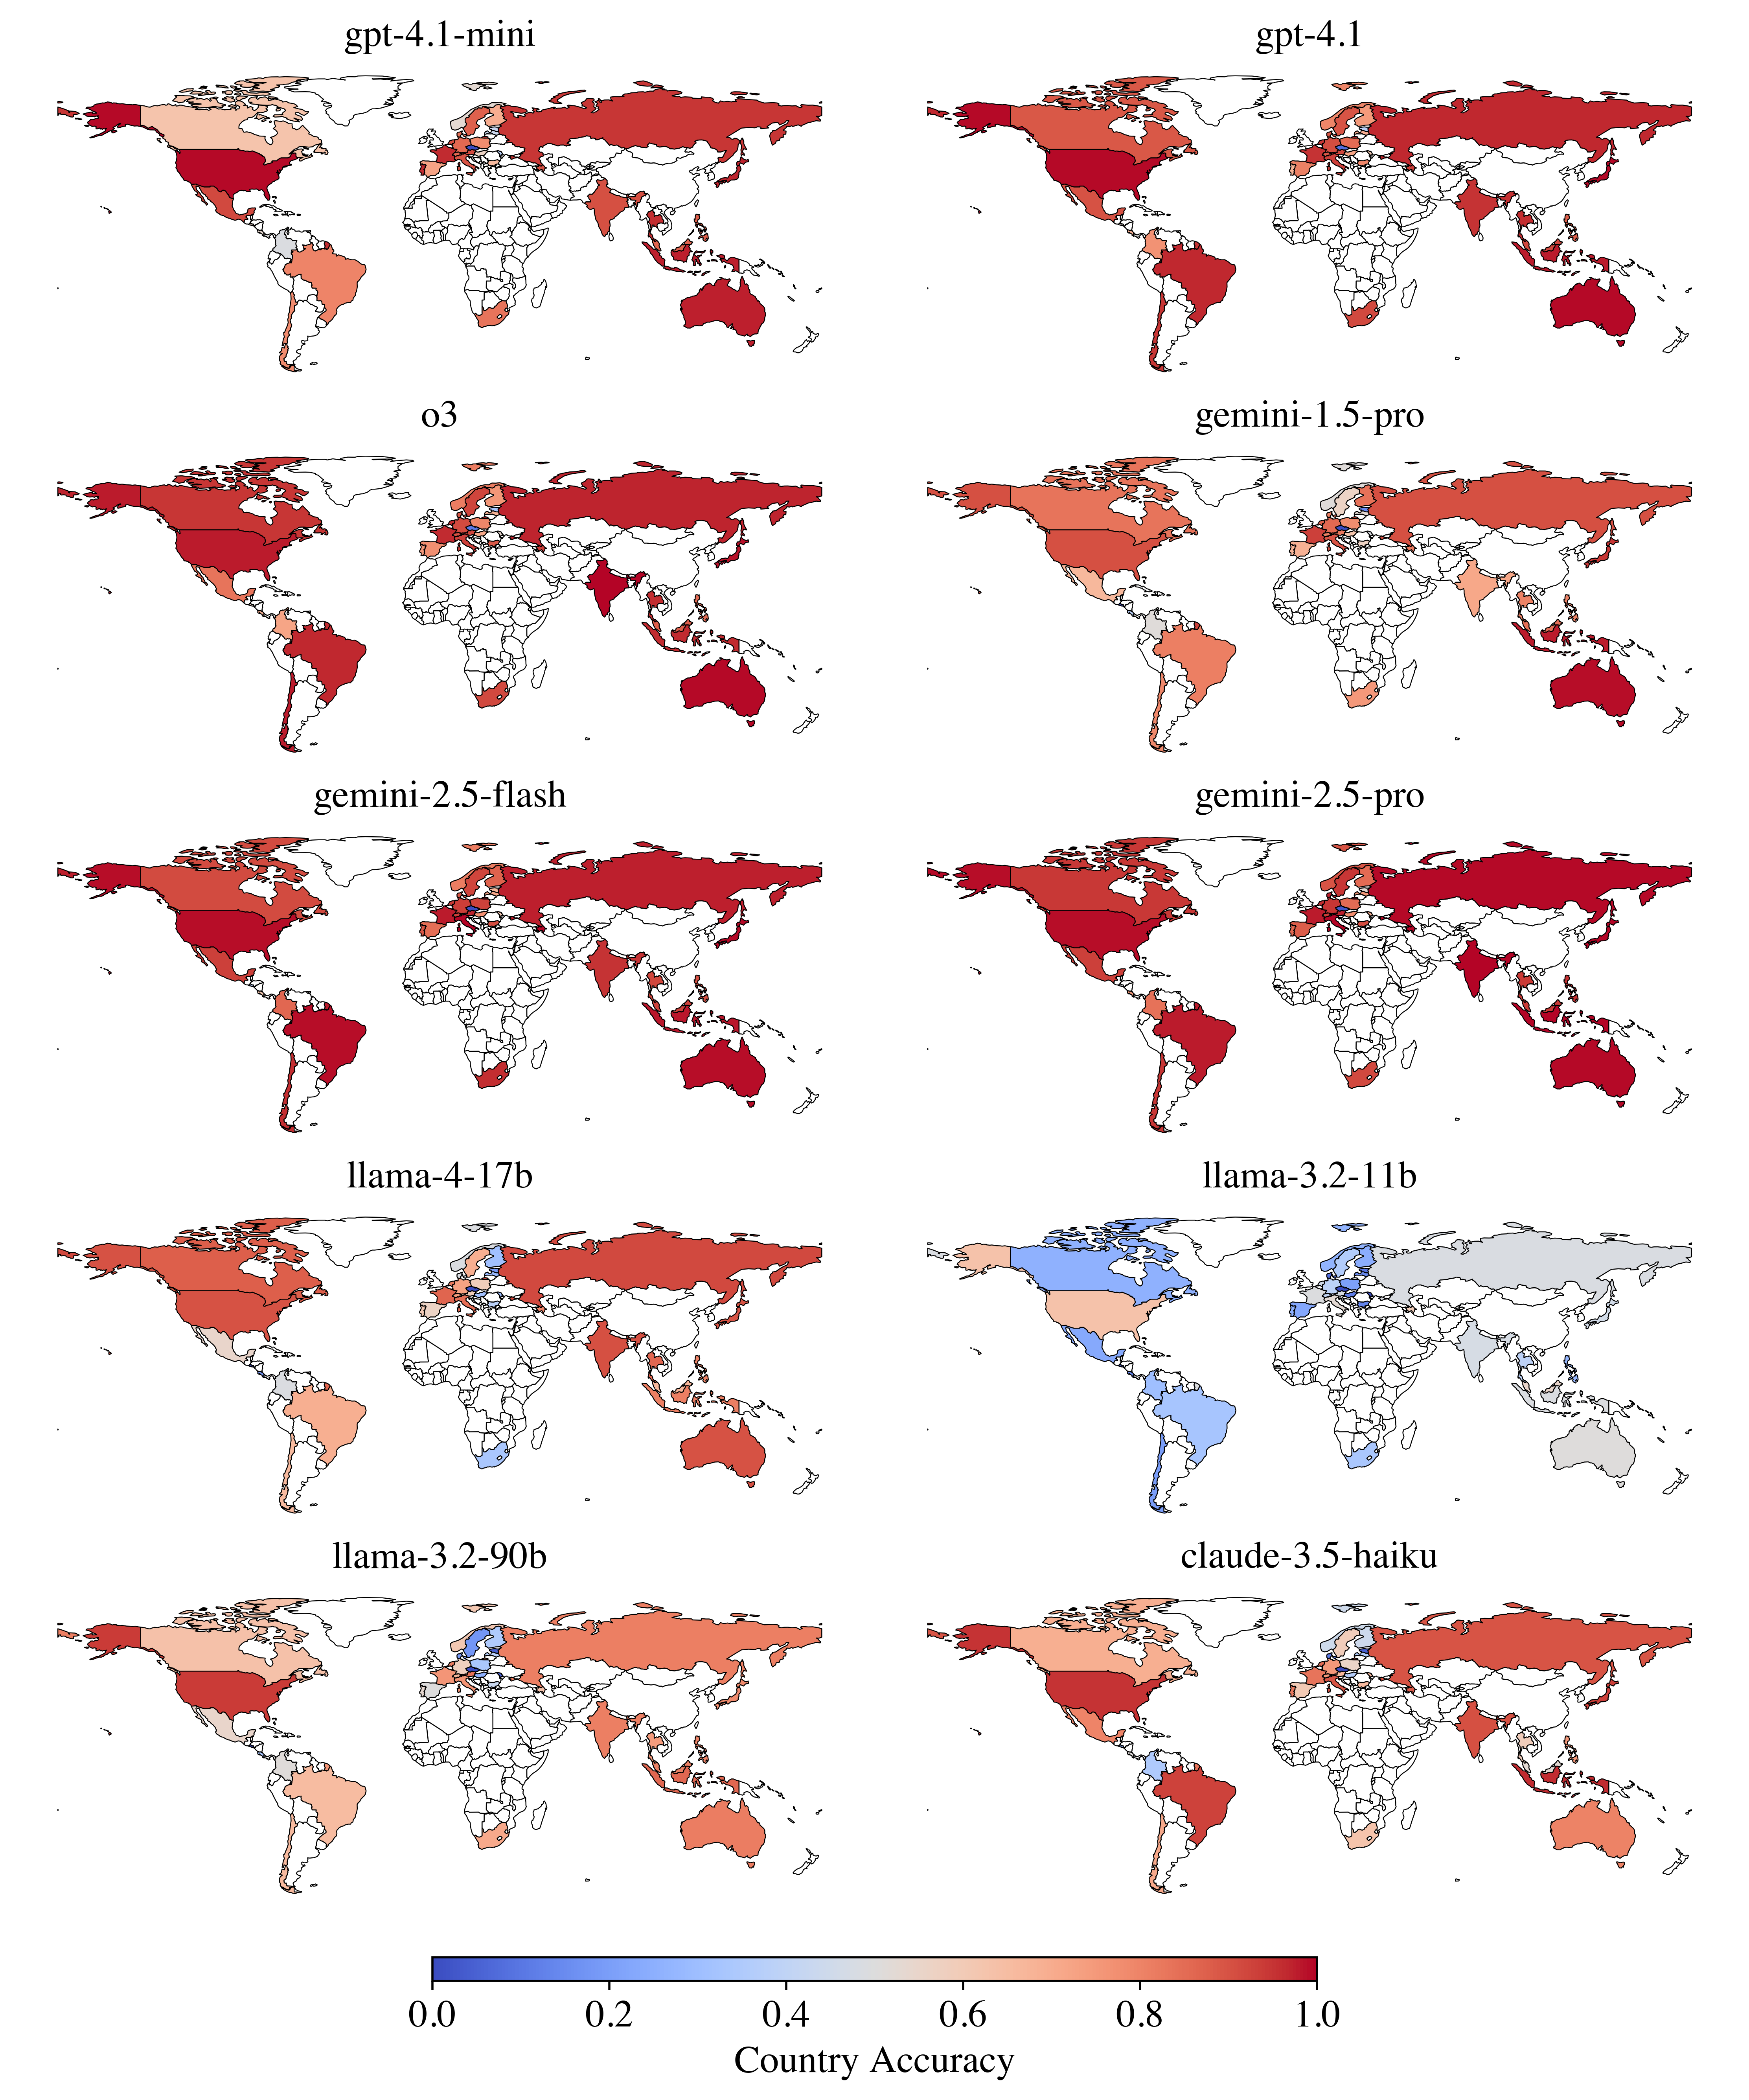

In [7]:
# 0. Load world shapefile once
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# 1. Prepare your DataFrame
df_1['match_int'] = df_1['country_match'].astype(int)

# 3. Set up subplot grid for 10 models (5 rows × 2 cols)
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(9, 10))
axes = axes.flatten()

# 4. Common colormap & normalization
cmap = "coolwarm"
norm = Normalize(vmin=0, vmax=1)

# USA aliases to remap into the shapefile’s official name
usa_aliases = ['usa', 'us', 'united states', 'united states of america']

# 5. Loop and plot each model in sorted order
for ax, model in zip(axes, models):
    df_m = df_1[df_1['model'] == model]

    # compute total & correct per true_country
    stats = (
        df_m
        .groupby('true_country', as_index=False)
        .agg(total=('match_int','size'),
             correct=('match_int','sum'))
    )
    stats['accuracy'] = stats['correct'] / stats['total']
    stats = stats[stats['total'] > THRESHOLD_1]

    # remap USA aliases
    stats.loc[
        stats['true_country'].str.lower().isin(usa_aliases),
        'true_country'
    ] = 'United States of America'

    # merge onto world map
    world_acc = world.merge(
        stats[['true_country','accuracy']],
        left_on='ADMIN',
        right_on='true_country',
        how='left'
    )

    # plot choropleth
    world_acc.plot(
        column='accuracy',
        cmap=cmap,
        norm=norm,
        ax=ax,
        legend=False,
        missing_kwds={"color": "white", "label": f"≤ {THRESHOLD_1} samples"},
        edgecolor='black',
        linewidth=0.35
    )
    ax.set_title(model)
    ax.set_axis_off()
    ax.set_ylim(-60, 90)

# 6. Hide any extra axes
for ax in axes[len(models):]:
    ax.set_visible(False)

# 7. Shared colorbar at bottom
plt.subplots_adjust(bottom=-0.02, wspace=0.01, hspace=0.1)

# Create a ScalarMappable to drive the colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm._A = []   # hack so that the mappable has a data array

# [left, bottom, width, height] in figure‐fraction coords
cax = fig.add_axes([0.25, -0.01, 0.5, 0.012])
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Country Accuracy")

plt.tight_layout()
plt.savefig("dataset1_map_heatmap.pdf", bbox_inches="tight", dpi=300)
plt.show()


### 3. Process dataframe - dataset 2

In [8]:
# Import the results of Dataset2
df_2 = pd.read_csv('dataset2_result.csv')
df_2.columns

Index(['image_file', 'model_used', 'confidence', 'street', 'city', 'state',
       'country', 'latitude', 'longitude', 'usage_info', 'environment',
       'scene_type', 'setting', 'landmark_recognition', 'text_and_signage',
       'cultural_indicators', 'spatial_context', 'image_id', 'true_city',
       'true_state', 'true_latitude', 'true_longitude', 'distance_km', 'model',
       'state_match', 'city_match'],
      dtype='object')

In [9]:
# Only states with ≥ THRESHOLD_2 samples (true ground‑truth examples) are shown
THRESHOLD_2 = 20

# 1. Count true_state samples per model & state
counts = (
    df_2
    .groupby(['model', 'true_state'])
    .size()
    .reset_index(name='n')
)

# 2. For each model, count how many countries exceed the THRESHOLD_2
result = (
    counts[counts['n'] > THRESHOLD_2]
    .groupby('model')
    .size()
    .reset_index(name='num_states')
)

# 3. Display the results
print("Number of countries per model with more than "
      f"{THRESHOLD_2} true_state samples:")
print(result)

Number of countries per model with more than 20 true_state samples:
              model  num_states
0  claude-3.5-haiku          51
1    gemini-1.5-pro          51
2  gemini-2.5-flash          51
3    gemini-2.5-pro          51
4           gpt-4.1          51
5      gpt-4.1-mini          51
6     llama-3.2-11b          51
7     llama-3.2-90b          51
8       llama-4-17b          51
9                o3          51


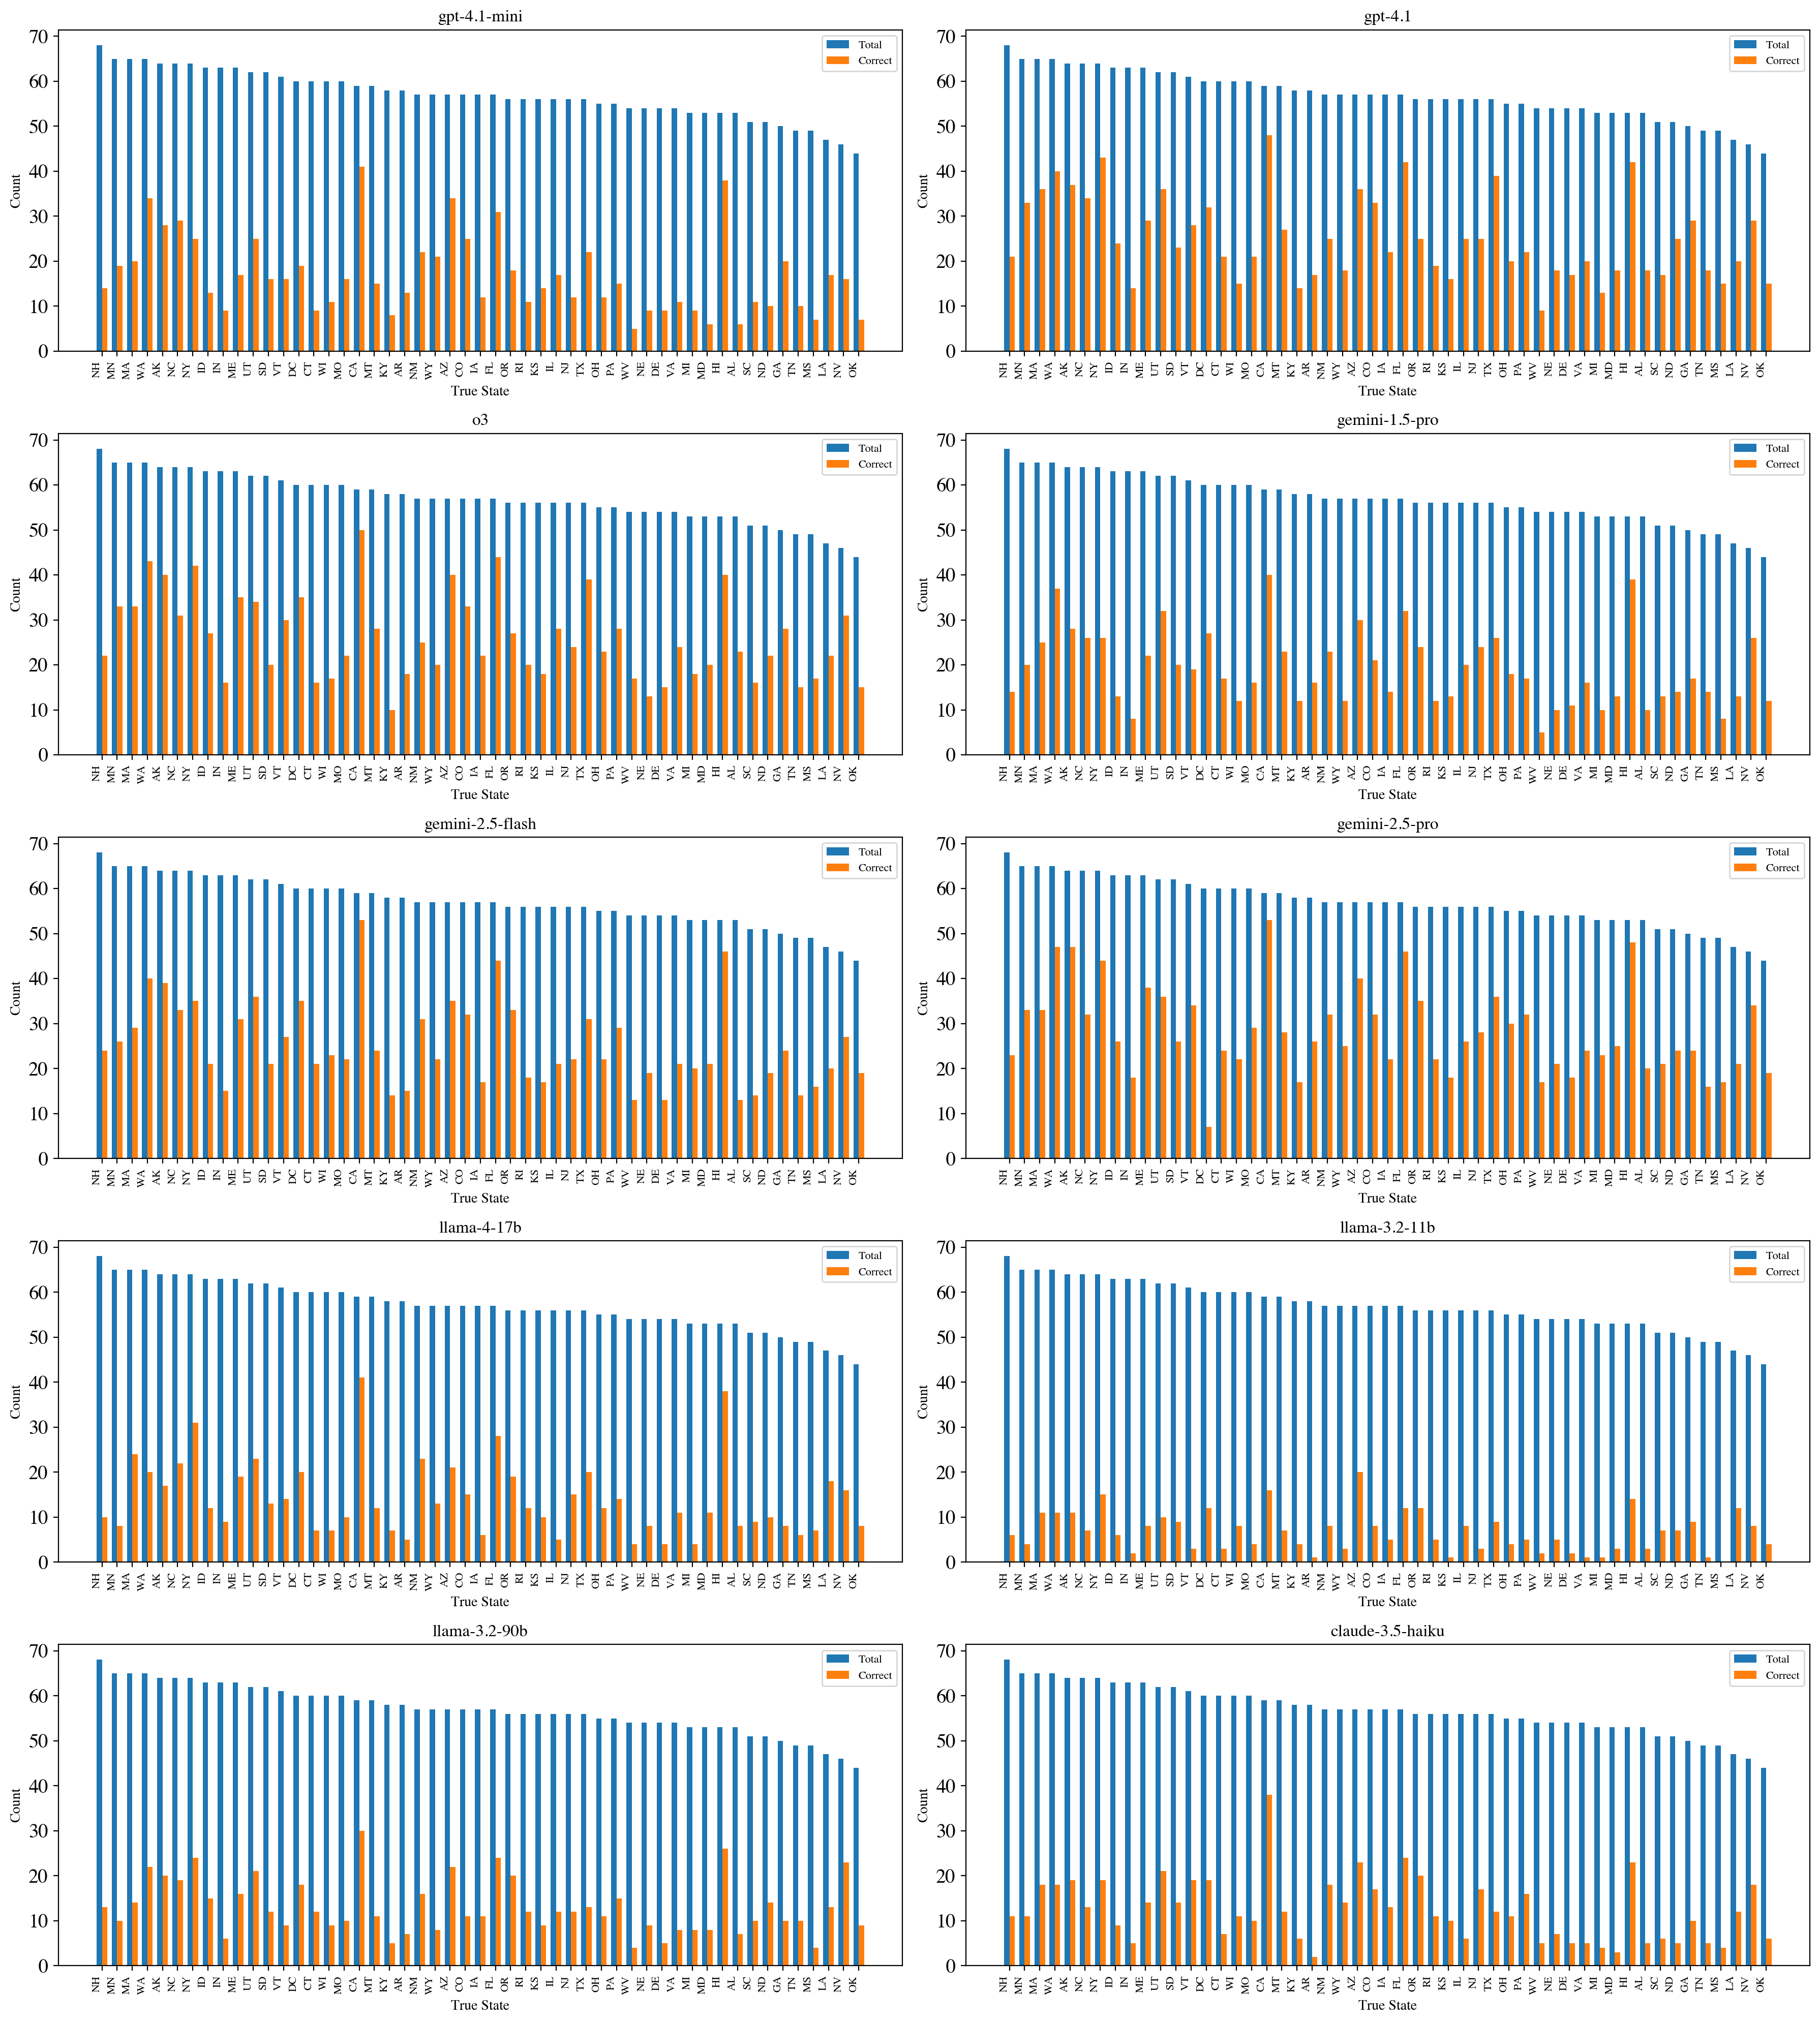

In [10]:
# 1. Get your models and compute grid size
models = [
    'gpt-4.1-mini',
    'gpt-4.1',
    'o3',
    'gemini-1.5-pro',
    'gemini-2.5-flash',
    'gemini-2.5-pro',
    'llama-4-17b',
    'llama-3.2-11b',
    'llama-3.2-90b',
    'claude-3.5-haiku',
]
n_models = len(models)
cols = 2
rows = (n_models + cols - 1) // cols  # ceil division

# 2. Set up the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4), dpi=200)
axes = axes.flatten()

# 3. Loop over models and plot on its own axis
for ax, model in zip(axes, models):
    # a) filter to this model
    df_m = df_2[df_2['model'] == model]

    # b) group by true_state
    stats = (
        df_m
        .assign(match_int=df_m['state_match'].astype(int))
        .groupby('true_state', as_index=False)
        .agg(
            total=('match_int', 'size'),     # number of ground‑truth examples
            correct=('match_int', 'sum')     # how many were predicted correctly
        )
        .query("total >= @THRESHOLD_2")       # only big enough bins
        .sort_values('total', ascending=False)
    )
    
    # c) if no bins pass THRESHOLD_2, hide axis
    if stats.empty:
        ax.set_visible(False)
        continue  

    # d) bar positions
    x = np.arange(len(stats))
    width = 0.35

    # e) draw bars
    ax.bar(x - width/2, stats['total'],   width, label='Total')
    ax.bar(x + width/2, stats['correct'], width, label='Correct')

    # f) formatting
    ax.set_title(model, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(stats['true_state'], rotation=90, ha='right', fontsize=8)
    ax.set_xlabel('True State', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.legend(fontsize=8)

# 4. Hide leftover axes if any
for ax in axes[n_models:]:
    ax.set_visible(False)

# 5. Final layout
plt.tight_layout()
plt.show()

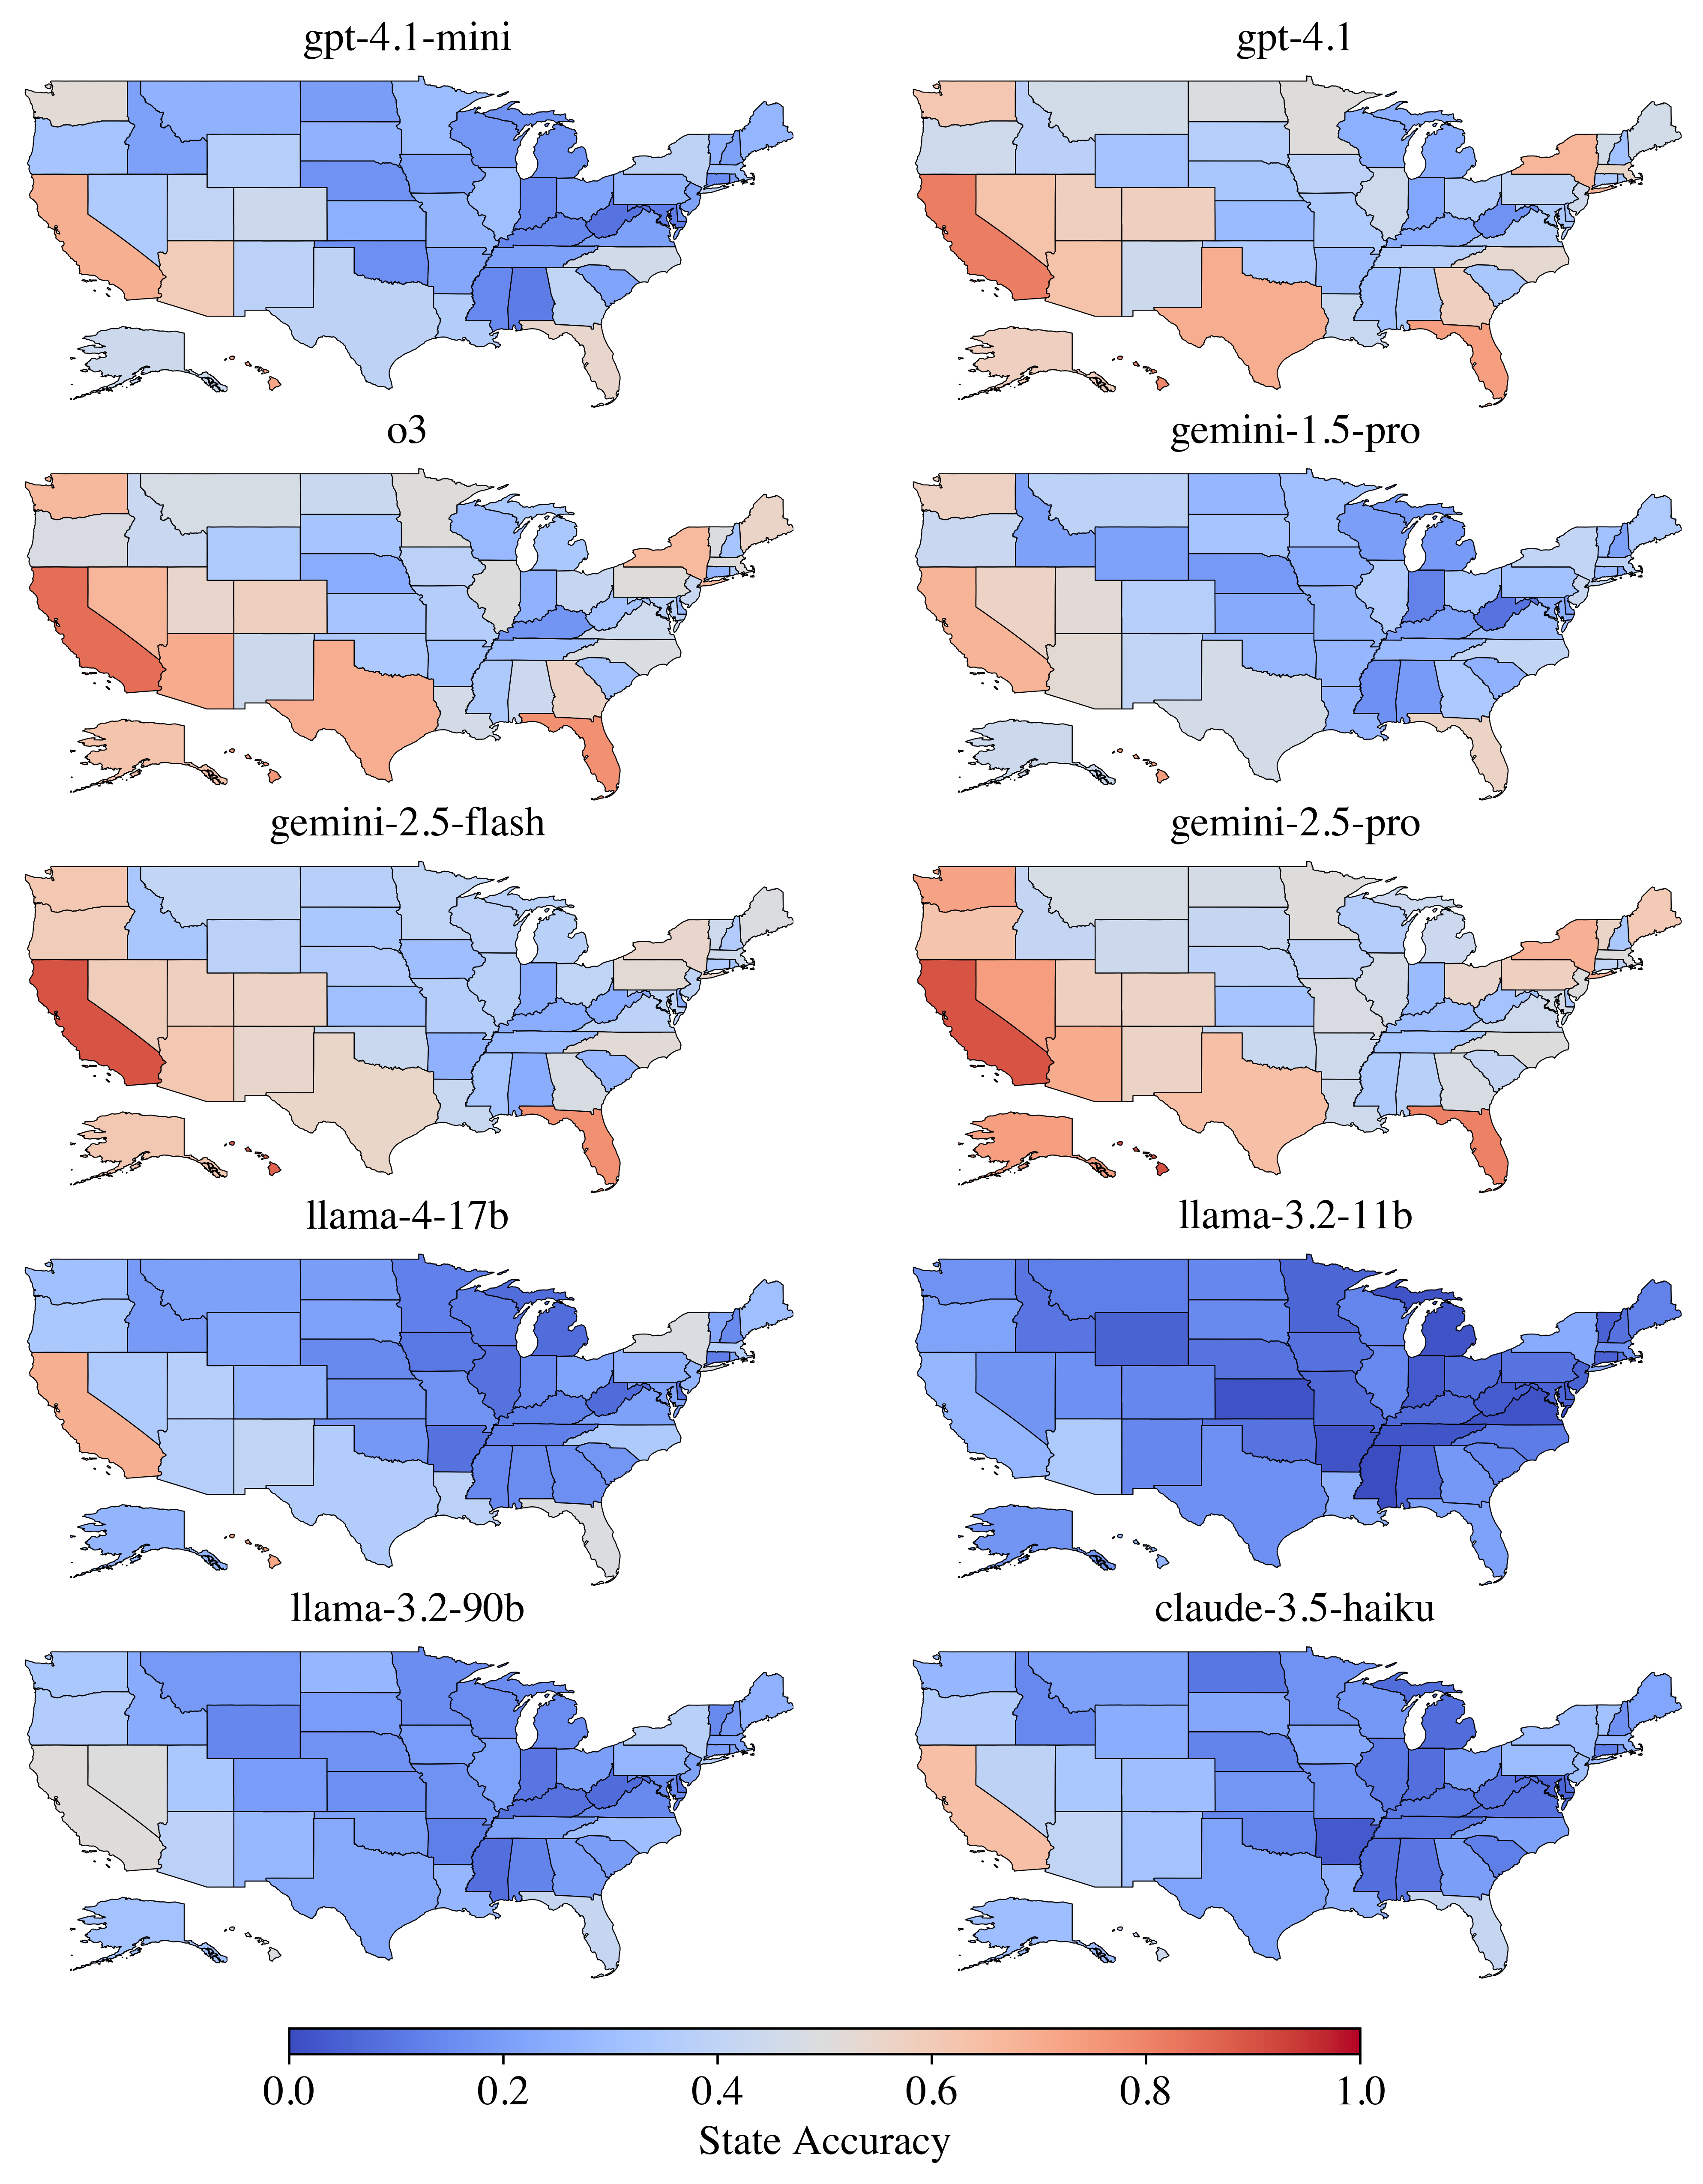

In [11]:
# 0. Load U.S. states shapefile once
states = gpd.read_file("./2018_us_state_20m/cb_2018_us_state_20m.shp")

# 1. Prepare your DataFrame
df_2['match_int'] = df_2['state_match'].astype(int)

# 2. Sort models lexicographically
models = [
    'gpt-4.1-mini',
    'gpt-4.1',
    'o3',
    'gemini-1.5-pro',
    'gemini-2.5-flash',
    'gemini-2.5-pro',
    'llama-4-17b',
    'llama-3.2-11b',
    'llama-3.2-90b',
    'claude-3.5-haiku',
]
# 3. Create a 5×2 grid for up to 10 models
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

# 4. Shared colormap & normalization
cmap = "coolwarm"
norm = Normalize(vmin=0, vmax=1)

for ax, model in zip(axes, models):
    # a) filter & aggregate
    df_m = df_2[df_2['model'] == model]
    stats = (
        df_m
        .groupby('true_state', as_index=False)
        .agg(total=('match_int', 'size'),
             correct=('match_int', 'sum'))
    )
    stats['accuracy'] = stats['correct'] / stats['total']
    stats = stats[stats['total'] > THRESHOLD_2]

    # b) merge accuracies onto states (by USPS code)
    states_acc = states.merge(
        stats[['true_state', 'accuracy']],
        left_on='STUSPS',
        right_on='true_state',
        how='left'
    )

    # c) main Lower‑48 map
    lower48 = states_acc[~states_acc['STUSPS'].isin(['AK', 'HI'])]
    lower48.plot(
        column='accuracy', cmap=cmap, norm=norm,
        ax=ax, legend=False, missing_kwds={"color": "white"},
        edgecolor='black', linewidth=0.35
    )
    ax.set_xlim(-125, -67)
    ax.set_ylim(24, 50)
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(model)

    # d) Alaska inset
    ax_ak = ax.inset_axes([0.04, 0.01, 0.25, 0.25])  # [x0, y0, width, height]
    alaska = states_acc[states_acc['STUSPS'] == 'AK']
    alaska.plot(
        column='accuracy', cmap=cmap, norm=norm,
        ax=ax_ak, legend=False, missing_kwds={"color": "white"},
        edgecolor='black', linewidth=0.35
    )
    ax_ak.set_xlim(-170, -130)
    ax_ak.set_ylim(50, 72)
    ax_ak.set_aspect('equal')
    ax_ak.set_axis_off()

    # e) Hawaii inset
    ax_hi = ax.inset_axes([0.2, 0.04, 0.20, 0.15])
    hawaii = states_acc[states_acc['STUSPS'] == 'HI']
    hawaii.plot(
        column='accuracy', cmap=cmap, norm=norm,
        ax=ax_hi, legend=False, missing_kwds={"color": "white"},
        edgecolor='black', linewidth=0.35
    )
    ax_hi.set_xlim(-161, -154)
    ax_hi.set_ylim(18, 23)
    ax_hi.set_aspect('equal')
    ax_hi.set_axis_off()

# Hide any leftover axes
for ax in axes[len(models):]:
    ax.set_visible(False)

# 5. Shared colorbar at the bottom
plt.subplots_adjust(bottom=-0.02, wspace=0.15, hspace=0.1)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cax = fig.add_axes([0.25, -0.05, 0.5, 0.012])
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("State Accuracy")

plt.savefig("dataset2_map_heatmap.pdf", bbox_inches="tight", dpi=300)
plt.show()